In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

xdf = pd.read_parquet('../hces-2023-24/data/sec-1-HCQ.parquet')
ydf = pd.read_parquet('../hces-2023-24/data/sec-3-HCQ.parquet')
zdf = pd.read_parquet('../hces-2023-24/data/sec-4-HCQ.parquet')
df = pd.read_parquet('../hces-2023-24/data/sec-4.1-FDQ.parquet')


df['online'] = df[[c for c in df if c.startswith('online_')]].values.any(axis=1) > 0
education = pd.CategoricalDtype([
    'not literate', 'literate with non-formal education', 'below primary', 'primary', 
    'upper primary/middle', 'secondary', 'higher secondary', 
    'diploma/certificate course (up to secondary)', 
    'diploma/certificate course (higher secondary)',
    'diploma/certificate course (graduation & above)', 
    'graduate', 'post graduate and above'
], ordered=True)
used_internet = pd.CategoricalDtype(['no', 'yes'], ordered=True)
ydf['edu_level'] = ydf['edu_level'].astype(education)
ydf['used_internet'] = ydf['used_internet'].astype(used_internet)
ydf = ydf.groupby(ydf.index.get_level_values(0)).agg({
    'edu_level': 'max',
    'used_internet': 'max'
})
xdf = xdf[['sector', 'state_name']]
zdf = zdf[['hh_size', 'employed_annual', 'hh_type', 'hoh_religion', 'caste', 'energy_source_cooking', 'energy_source_lighting', 'rationcard_type',
           'has_benefited_from_pmgky']]
df = pd.concat((df, xdf, ydf, zdf), axis=1)
df.head()

,used_ration_card,procured_rice,procured_wheat,procured_grain,procured_sugar,procured_pulses,procured_edible_oil,procured_other,online_groceries,online_milkprod,...,used_internet,hh_size,employed_annual,hh_type,hoh_religion,caste,energy_source_cooking,energy_source_lighting,rationcard_type,has_benefited_from_pmgky
hhid,,,,,,,,,,,,,,,,,,,,,
22300101,no,False,False,False,False,False,False,False,False,False,...,yes,4,yes,1,Hinduism,other backward class (OBC),LPG,electricity (incl. generated by solar or wind ...,Above Poverty Line (APL),no
22300201,no,False,False,False,False,False,False,False,False,False,...,yes,4,yes,1,Hinduism,other backward class (OBC),LPG,electricity (incl. generated by solar or wind ...,Above Poverty Line (APL),no
22300202,no,False,False,False,False,False,False,False,False,False,...,yes,2,no,9,Hinduism,other backward class (OBC),LPG,electricity (incl. generated by solar or wind ...,Above Poverty Line (APL),no
22300203,no,False,False,False,False,False,False,False,False,False,...,no,2,no,9,Hinduism,other backward class (OBC),LPG,electricity (incl. generated by solar or wind ...,Above Poverty Line (APL),no
22300204,no,False,False,False,False,False,False,False,False,False,...,yes,2,yes,2,Christianity,other backward class (OBC),LPG,electricity (incl. generated by solar or wind ...,Above Poverty Line (APL),no


1. What proportion of households have used any online shopping?
2. Urban / Rural and statewise representation of online shoppers?
3. Does the education of the HoH have an impact on online shopping?
4. Used internet vs online shopping?
5. Of the people who don't shop online, how many used ration cards?
6. Impact of any household member being employed on online shopping?
7. Impact of energy source for cooking for online shopping?
8. Impact of ration card type on online shopping?
9. Impact of PMGKY on online shopping?

In [2]:
# 1. What proportion of households have used any online shopping?
df.groupby('online')['multiplier'].sum() / df['multiplier'].sum()

online
False    0.929041
True     0.070959
Name: multiplier, dtype: float64

In [99]:
# 2. Urban / Rural and statewise representation of online shoppers?
ct = pd.crosstab(index=df['sector'], columns=df['online'], values=df['multiplier'], aggfunc='sum')
ct / ct.sum(axis=1).values.reshape(-1, 1)

online,False,True
sector,,
rural,0.975234,0.024766
urban,0.837594,0.162406


In [8]:
from scipy.stats import chi2_contingency
chi2_contingency(ct).pvalue

0.0

In [45]:
# 2.a Statewise representation of online shoppers
import geopandas as gpd

gdf = gpd.read_file('../maps/States/Admin2.shp').set_index('ST_NM', verify_integrity=True)
ct = pd.crosstab(index=df['state_name'], columns=df['online'], values=df['multiplier'], aggfunc='sum')
state_online = (ct[True] / ct[True].sum()).sort_values(ascending=False)
gdf['online_pc'] = state_online


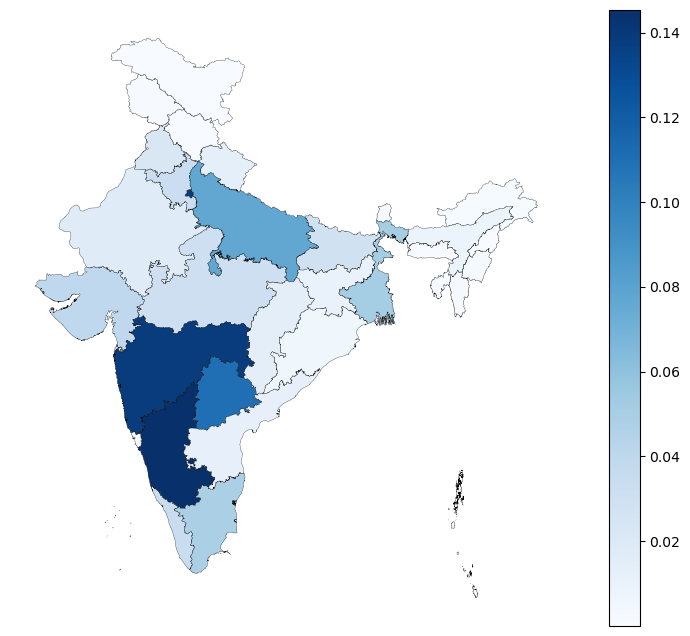

In [48]:
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot('online_pc', cmap='Blues', ec='k', lw=0.2, legend=True, ax=ax)
ax.set_axis_off()

In [94]:
# Does the education of the HoH have an impact on online shopping?
ct = pd.crosstab(index=df['edu_level'], columns=df['online'], values=df['multiplier'], aggfunc='sum')
chi2_contingency(ct).pvalue

0.0

In [97]:
xx = ct / ct.sum(axis=1).values.reshape(-1, 1)
xx
# xx[True].sort_values(ascending=False).plot(kind='barh')
# plt.grid()

online,False,True
edu_level,,
not literate,0.995897,0.004103
literate with non-formal education,0.992350,0.007650
below primary,0.992402,0.007598
primary,0.986684,0.013316
upper primary/middle,0.980338,0.019662
secondary,0.960035,0.039965
higher secondary,0.930664,0.069336
diploma/certificate course (up to secondary),0.954234,0.045766
diploma/certificate course (higher secondary),0.918016,0.081984


In [115]:
# Of the people who don't shop online, how many used ration cards?
ct = pd.crosstab(index=df['used_ration_card'], columns=df['online'], values=df['multiplier'], aggfunc='sum')
chi2_contingency(ct).pvalue

0.0

In [117]:
ct / ct.sum(axis=1).values.reshape(-1, 1)

online,False,True
used_ration_card,,
no,0.845576,0.154424
yes,0.964382,0.035618


In [73]:
# Ration card type
ct = pd.crosstab(index=df['rationcard_type'], columns=df['online'], values=df['multiplier'], aggfunc='sum')
chi2_contingency(ct).pvalue

0.0

In [77]:
ct / ct.sum(axis=1).values.reshape(-1, 1)

online,False,True
rationcard_type,,
Above Poverty Line (APL),0.914327,0.085673
Antyodaya Anna Yojana (AAY),0.960976,0.039024
Below Poverty Line (BPL),0.934304,0.065696
No ration card,0.829708,0.170292
Others,0.938142,0.061858
Priority House Holds (PHH),0.978781,0.021219
State Food Security Scheme (SFSS),0.945906,0.054094


In [81]:
# Impact of any household member being employed on online shopping?
ct = pd.crosstab(index=df['employed_annual'], columns=df['online'], values=df['multiplier'], aggfunc='sum')
ct / ct.sum(axis=1).values.reshape(-1, 1)

online,False,True
employed_annual,,
no,0.930054,0.069946
yes,0.928921,0.071079


In [86]:
# Impact of energy source for cooking for online shopping?
ct = pd.crosstab(index=df['energy_source_cooking'], columns=df['online'], values=df['multiplier'], aggfunc='sum').fillna(value=0)
ct / ct.sum(axis=1).values.reshape(-1, 1)

online,False,True
energy_source_cooking,,
LPG,0.902585,0.097415
charcoal,1.000000,0.000000
"coke,coal",0.980621,0.019379
dung cake,0.996435,0.003565
electricity (incl. generated by solar or wind power generators),0.843062,0.156938
firewood and chips,0.990052,0.009948
gobar gas,0.943080,0.056920
kerosene,0.995616,0.004384
no cooking arrangement,0.878411,0.121589


In [91]:
# Impact of PMGKY on online shopping?
ct = pd.crosstab(index=df['has_benefited_from_pmgky'], columns=df['online'], values=df['multiplier'], aggfunc='sum').fillna(value=0)
ct / ct.sum(axis=1).values.reshape(-1, 1)

online,False,True
has_benefited_from_pmgky,,
no,0.88034,0.11966
yes,0.96968,0.03032


In [101]:
import numpy as np

In [106]:
X = np.random.rand(5, 2)
X.sort(axis=1)

In [108]:
X

array([[0.50731924, 0.51397147],
       [0.08898067, 0.56138418],
       [0.14016409, 0.72294501],
       [0.22322921, 0.71482404],
       [0.30997473, 0.3467448 ]])

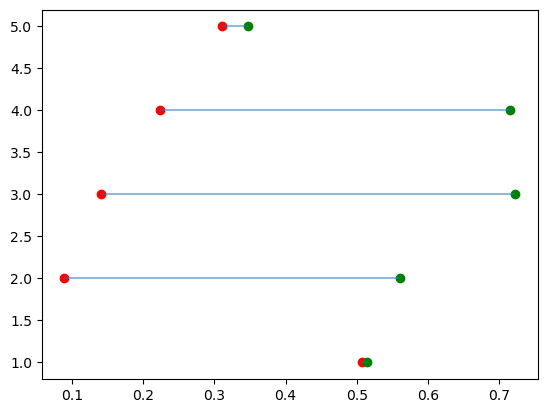

In [114]:
pdf = [
    {'key': 'Sector', 'min': 'Rural', 'max': 'Urban', 'vmin': }
]

In [118]:
ct = pd.crosstab(index=df['hoh_religion'], columns=df['online'], values=df['multiplier'], aggfunc='sum').fillna(value=0)
ct / ct.sum(axis=1).values.reshape(-1, 1)

online,False,True
hoh_religion,,
Buddhism,0.948042,0.051958
Christianity,0.925033,0.074967
Hinduism,0.928150,0.071850
Islam,0.941004,0.058996
Jainism,0.781001,0.218999
Not reported,0.722190,0.277810
Others,0.906608,0.093392
Sikhism,0.913326,0.086674
Zoroastrianism,0.361056,0.638944


In [119]:
chi2_contingency(ct)

Chi2ContingencyResult(statistic=36742064.61898778, pvalue=0.0, dof=8, expected_freq=array([[1.46762070e+08, 1.12095259e+07],
       [8.07980969e+08, 6.17126997e+07],
       [2.24318867e+10, 1.71332289e+09],
       [3.17532652e+09, 2.42527955e+08],
       [5.77654261e+07, 4.41205985e+06],
       [4.13647089e+06, 3.15939107e+05],
       [7.03664368e+07, 5.37451122e+06],
       [4.02794634e+08, 3.07650121e+07],
       [4.16184300e+05, 3.17877001e+04]]))

In [120]:
ct = pd.crosstab(index=df['caste'], columns=df['online'], values=df['multiplier'], aggfunc='sum').fillna(value=0)
ct / ct.sum(axis=1).values.reshape(-1, 1)

online,False,True
caste,,
Not reported,0.840771,0.159229
other backward class (OBC),0.930900,0.069100
others,0.889558,0.110442
scheduled caste (SC),0.961270,0.038730
scheduled tribe (ST),0.971421,0.028579


In [59]:
vdf = pd.DataFrame.from_records([
    {
        "key": "Sector", "min": "Rural", "max": "Urban", "vmin": 0.025, "vmax": 0.16,
        "caption": "Urban households 6X more likely than rural ones to shop online"
    },
    {
        "key": "Education (of head of household)",
        "min": "Graduate (1 in 10 shop online)",
        "max": "Postgraduate (1 in 5 shop online)",
        "vmin": 0.11,
        "vmax": 0.2,
        "caption": ""
    },
    {
        "key": "Ration Card",
        "min": "PHH Card",
        "max": "No card",
        "vmin": 0.02,
        "vmax": 0.17,
        "caption": "Households w/o a ration card 8X more likely to shop online"
    },
    {
        "key": "Energy Source for Cooking",
        "min": "LPG",
        "max": "Piped Gas",
        "vmin": 0.09,
        "vmax": 0.38,
        "caption": "Homes with piped gas ~4X more likely to shop online"
    },
    {
        "key": "PMGKY",
        "min": "PMGKY Beneficiary",
        "max": "Non-Beneficiaries 4x more likely to shop online",
        "vmin": 0.03,
        "vmax": 0.12,
        "caption": ""
    },
    {
        "key": "Caste",
        "min": "ST",
        "max": "Others / Not Reported",
        "vmin": 0.03,
        "vmax": 0.27,
        "caption": "3% of ST homes and 27% of upper caste homes shop online"
    },
])
vdf['diff'] = vdf['vmax'] - vdf['vmin']
vdf.sort_values('diff', inplace=True)
vdf['vmin'] *= 100
vdf['vmax'] *= 100

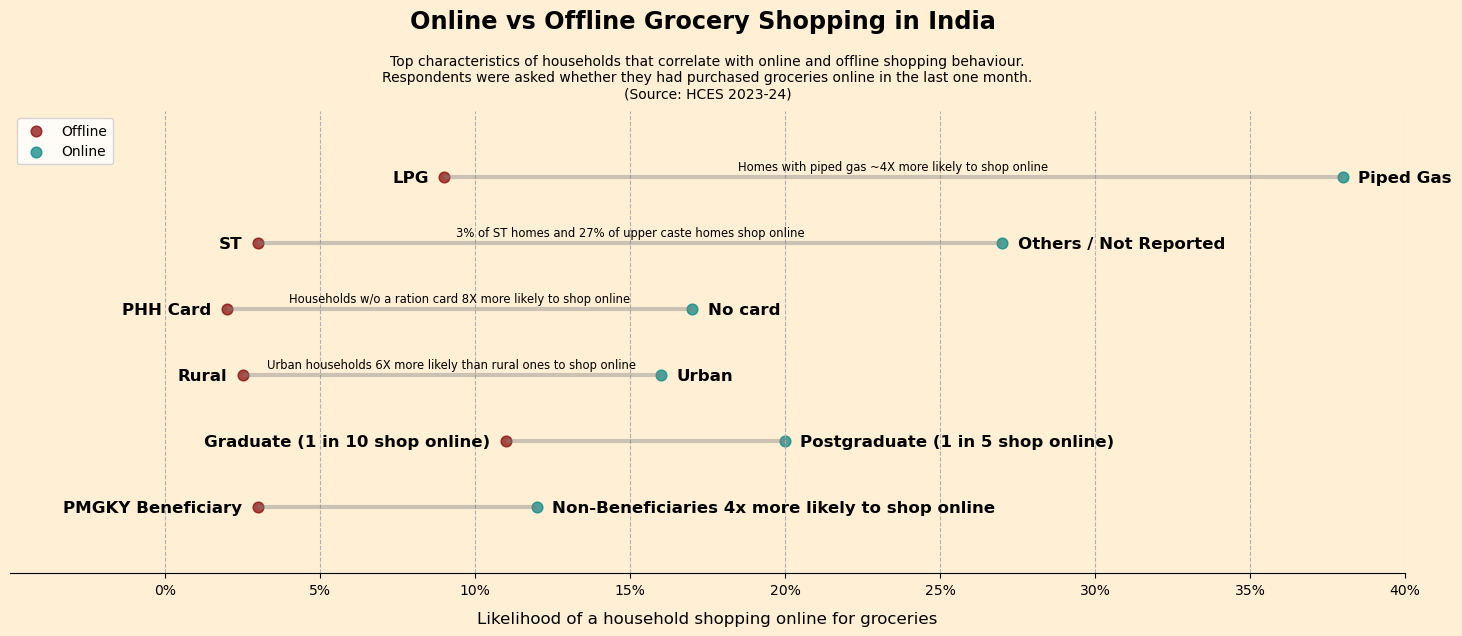

In [71]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.hlines(np.arange(6), vdf['vmin'], vdf['vmax'], alpha=0.4, linewidth=3, color='grey')
off = ax.scatter(vdf['vmin'], np.arange(6), c='maroon', s=60, alpha=0.7, label='Offline')
on = ax.scatter(vdf['vmax'], np.arange(6), c='teal', s=60, alpha=0.7, label='Online')
ax.set_xticks(np.arange(0, 45, 5),[f"{k:d}%" for k in np.arange(0, 45, 5)])
ax.set_xlim(-5, 40)
ax.set_ylim(-1, 6)
ax.yaxis.set_ticks([])

for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)
ax.grid(axis='x', linestyle='dashed')

ax.set_xlabel('Likelihood of a household shopping online for groceries', fontsize='large', labelpad=10)
fig.patch.set_facecolor('papayawhip')
ax.set_facecolor('papayawhip')


fig.suptitle('Online vs Offline Grocery Shopping in India', fontsize='xx-large', fontweight='bold', fontfamily='DejaVu Sans', y=1.05, x=0.51)
ax.set_title(
    ('Top characteristics of households that correlate with online and offline shopping behaviour.'
     '\nRespondents were asked whether they had purchased groceries online in the last one month.'
     '\n(Source: HCES 2023-24)'),
    fontsize='medium', pad=10, loc='center')

for i, (ix, row) in enumerate(vdf.iterrows()):
    ax.text(row['vmin'] - 0.5, i - 0.08, row['min'], horizontalalignment='right', fontsize='large', fontweight='bold')
    ax.text(row['vmax'] + 0.5, i - 0.08, row['max'], horizontalalignment='left', fontsize='large', fontweight='bold')
    if row['caption']:
        ax.text((row['vmin'] + row['vmax']) / 2, i + 0.1, row['caption'], ha='center', fontsize='small')

ax.legend([off, on], ['Offline', 'Online'], loc='upper left')